# MLESAC Implementaion

In [108]:
#Implement RANSAC algorithm to detect the box in the image
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import matplotlib.cm as cm
import cv2
from scipy import ndimage
import time

#load data from MAT
def loadData(example):
  example = str(example)
  data = scipy.io.loadmat("C:/Users/vicky/Downloads/Project_Computer_Vision/Project_1/data/example"+example+"kinect.mat")

  # print(data['distances'+example].shape)
  # print(data['amplitudes'+example].shape)
  # print(data['cloud'+example].shape)
  return data

#visualize raw data
def visualizeData(data):
  plt.imshow(data['distances'+example], cmap='jet')
  plt.colorbar(label='Distance (units)')  # Add a colorbar for interpretation
  plt.title('Raw Data visualization')
  plt.show()



def RANSAC(data,threshold, iteration, use_mlesac=True, gamma=0.9):
    '''
    :param data: pointcloud
    :param iteration: Maximum number of iterations
    :param threshhold: Margin for inliers
    :return:
    '''
    data = data.reshape(-1,3) # we dont care about preserving  i,j as such but only care about x,y,z
    #final shape will be (217088, 3) and the last column will access the z component of the point cloud

    #check if z component is zero or not
    b_mask = data[:, 2] != 0 #boolean masking of the last column
    valid_data = data[b_mask] #filter out the rows with invalid z component
    min_cost = float('inf')
    best_model = None
    max_inliers_count = 0

    for _ in range(iteration):

        #sample 3 points for a 3d pointcloud
        possible_inliers = sample_random_points(valid_data, 3) ####vicky

        #get normal vector for the plane
        p1p2 = possible_inliers[1] - possible_inliers[0]
        p1p3 = possible_inliers[2] - possible_inliers[0]
        normal = np.cross(p1p2, p1p3)

        # using 1st point as all will have approx same d value
        d = -np.dot(normal, possible_inliers[0]) ##distance from to origin to the plane along the normal vector

        #we will calculate the distance matrix contains the each point's distance to our plane (the plane formed by sampled three points)
        dist_vec = np.abs(valid_data @ normal + d)/np.linalg.norm(normal)

        if use_mlesac:
            inliers_cost = dist_vec[dist_vec < threshold]
            outliers_cost = gamma if gamma is not None else threshold * 2
            cost = np.sum(inliers_cost) + np.sum(outliers_cost * (dist_vec >= threshold))
            if cost < min_cost:
                min_cost = cost
                max_inliers = valid_data[dist_vec < threshold]
                best_model = (normal, d)

        else: 
            also_inliers = valid_data[dist_vec < threshold] ###boolean indexing

            if len(also_inliers) > max_inliers_count:
                max_inliers_count = len(also_inliers)
                max_inliers = also_inliers
                best_model = (normal, d) #possible plan, solving the model using the inliers

    #print("shape you want" , max_inliers.shape)
    return best_model, max_inliers ## best model should save all the inliers

def sample_random_points(data, k):
    #sample k points from the data
    radnom_index = np.random.choice(np.arange(data.shape[0]), size=k)
    random_points = data[radnom_index]
    return random_points

#Mask for given PC with inliers
def getMask(PC, max_inliers):
    data_2d = PC.reshape(-1, 3)
    mask = np.zeros([PC.shape[0],PC.shape[1]])
    mask = np.isin(data_2d, max_inliers).all(axis=1).reshape(PC.shape[0], PC.shape[1]) #vicky
    return mask

#find the floor plane
def find_floor_plane(data, thresh, iteration):
    best_floor_plane, max_inliers = RANSAC(data,thresh, iteration )
    return best_floor_plane, max_inliers

def find_top_plane(PC,mask):
    inverted_mask = 1 - mask
    top_cloud = np.stack((inverted_mask*PC[:,:,0], inverted_mask*PC[:,:,1], inverted_mask*PC[:,:,2]), axis=-1)

    best_plane_top, inliers_top = RANSAC(top_cloud.reshape(-1,3), 0.01, 100) #0.04
    #print("inliers top:  " , inliers_top)
    mask_top=getMask(top_cloud, inliers_top)
    visualize_mask(mask_top)####

    #clean the generated mask with morphological
    struc_elem = np.ones((5, 5), np.uint8)
    cleaned_mask = opening(closing(mask_top,struc_elem),struc_elem)

    # Extract the largest connected component
    largest_component = largest_connected_comp(cleaned_mask)
    return largest_component, best_plane_top

def visualize_mask(mask):
  plt.imshow(mask, cmap='jet')
  plt.title('Visualization of mask')
  plt.show()

##now we have to find the largest dominant plane

def largest_connected_comp(mask):

    #label connected components
    mask_labels, num_features = ndimage.label(mask)

    #count the number of pixel in each component
    pixel_sizes = ndimage.sum(mask, mask_labels, range(num_features + 1))

    # Extract the largest connected component by comparing indexes
    largest_component = pixel_sizes.argmax()
    return (mask_labels == largest_component)

def find_corners(mask):
    # Find contours
    #trying to find the corners of the mask later those corners can be use to compute the
    #dimensions of the boxes effectively

    #other approach left to try (will see later)

    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    if not contours:
      return None


    # Approximating polygon to extract corners
    epsilon = 0.1 * cv2.arcLength(largest_contour, True)
    corners = cv2.approxPolyDP(largest_contour, epsilon, True)
    if len(corners) != 4:
      return None
    return corners

def box_visualization(bool_closed, largest_component , PC_shape , corners):
    #use the corners to visualise the box dimensions
    '''
    parameters-

    bool_closed: (0,1)
    largest_component
    PC_shape: shape of the pont cloud
    corners: found corners (4 nos)

    '''

    # Create an zero image for visualisation
    sample_image = np.zeros(PC_shape)

    # assigning RGB Values to the all mask
    sample_image[bool_closed == 1] = [ 0, 1, 0]
    sample_image[bool_closed == 0] = [0, 0, 1]
    sample_image[largest_component == 1] = [1, 0, 0]
    #print("corners:" , corners)
    corners1 = corners.squeeze()

    # Plot the corners
    fig, ax = plt.subplots()
    ax.imshow(sample_image)

    ax.plot([corners1[0][0], corners1[1][0]], [corners1[0][1], corners1[1][1]], 'b-',linewidth=3)  # Line between 1st and 2nd corner
    ax.plot([corners1[1][0], corners1[2][0]], [corners1[1][1], corners1[2][1]], 'b-',linewidth=3)  # Line between 2nd and 3rd corner
    ax.plot([corners1[2][0], corners1[3][0]], [corners1[2][1], corners1[3][1]], 'b-',linewidth=3)  # Line between 3rd and 4th corner
    ax.plot([corners1[3][0], corners1[0][0]], [corners1[3][1], corners1[0][1]], 'b-',linewidth=3)  # Line between 4th and 1st corner

    # top, left, bottom, right corners
    offset = 50 #distance to the label

    ax.text(corners1[0][0], corners1[0][1] - offset, 'top', color='b', fontsize=10, ha='center', va='center')
    ax.text(corners1[1][0] - offset, corners1[1][1], 'left', color='b', fontsize=10, ha='center', va='center')
    ax.text(corners1[2][0], corners1[2][1] + offset, 'bottom', color='b', fontsize=10, ha='center', va='center')
    ax.text(corners1[3][0] + offset, corners1[3][1], 'right', color='b', fontsize=10, ha='center', va='center')

    plt.axis('off')
    plt.show()

#get difference between planes
def compute_height(best_floor_plane, best_top_plane):
    #Hieght: distance between parellel planes
    #we have normal and d for both of the planes
    #floor plane: best model = (noraml, d)
    #top plane: best_top_model = (normal, d)
    distance = 0
    # #check if both the normals are parellel or not
    # parallel_condition = np.allclose(best_floor_plane[0], best_top_plane[0]) or np.allclose(-best_floor_plane[0], best_top_plane[0])
    # print('Parallel= ',parallel_condition)
    #return true if both normals are same

    distance = np.abs(best_floor_plane[1] - best_top_plane[1])/np.linalg.norm(best_floor_plane[0]) #absolute difference between both plane.

    return distance

def calculate_dimensions(corners):
    # Calculate for each pairs distances
    distances = [np.linalg.norm(np.array(corners[i]) - np.array(corners[j])) for i in range(len(corners)) for j in range(i + 1, len(corners))]

    # two largest will be lenghth and then width
    sorted_distances = sorted(list(set(distances)))
    width = np.average(sorted_distances[:2])
    length = np.average(sorted_distances[2:])

    return length, width

#morphological operators
def dilate(mask, struc_elem, iterations):
    dilated_mask = cv2.dilate(mask.astype(np.uint8), kernel=struc_elem, iterations=iterations)
    return dilated_mask
    #we can use plt.imshow(dilated_mask) as our return value directly here
def erode(mask, struc_elem, iterations):
    eroded_mask = cv2.erode(mask.astype(np.uint8), kernel=struc_elem, iterations=iterations)
    return eroded_mask
def opening(mask, struc_elem):
    opened_mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, kernel = struc_elem)
    return opened_mask
def closing(mask, struc_elem):
    closed_mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel = struc_elem)
    return closed_mask

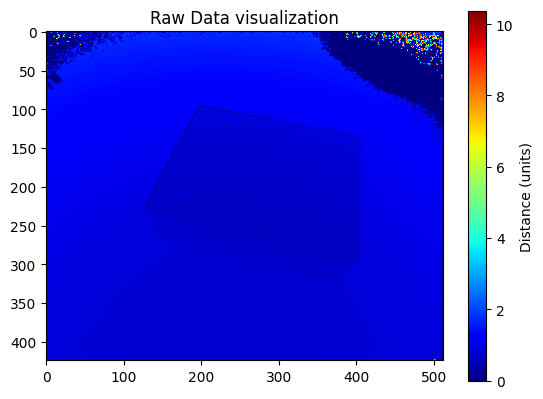

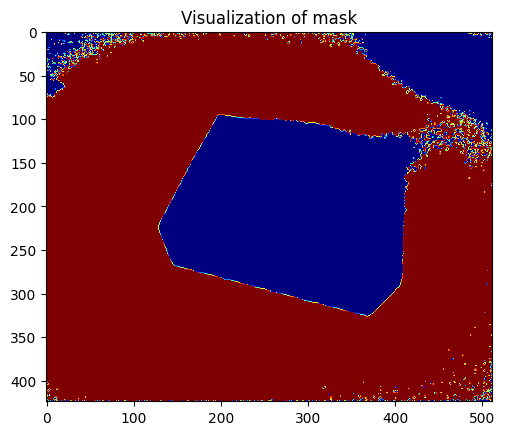

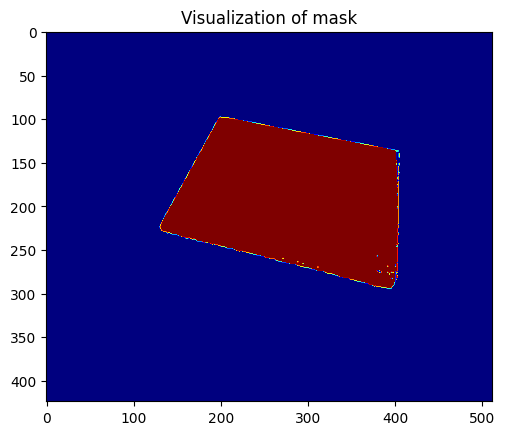

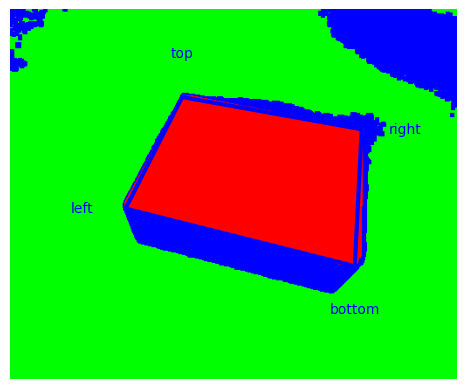

Distance between top and bottom (height) is: 0.74.
Length of the box is 260.88
Width of the box is 150.38
Time taken to run the code: 1.01 seconds.


In [110]:
#start here
example = '1'
data = loadData(example)

visualizeData(data)

A,D,PC = data['distances'+example], data['amplitudes'+example],data['cloud'+example]

#time calculation
start_time = time.time()

#get bottom plane
best_floor_plane, max_inliers = find_floor_plane(PC, 0.03 ,100) #0.04
#visualize mask here
mask = getMask(PC, max_inliers)
visualize_mask(mask)

#get top mask
largest_component, best_top_plane = find_top_plane(PC, mask)
#print(largest_component)
#get corners
corners = find_corners(largest_component)
end_time = time.time()
#apply morphological
#structuring_element
#shape of the elem is rectangular (5,5)
struc_elem = np.ones((5, 5), np.uint8)
#kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
bool_closed = closing(mask, struc_elem)

box_visualization(bool_closed,largest_component,PC.shape,corners)

height = compute_height(best_floor_plane,best_top_plane)

print(f"Distance between top and bottom (height) is: {format(height, '.2f')}.")


length, width= calculate_dimensions(corners)

print('Length of the box is', format(length, '.2f'))
print('Width of the box is', format(width, '.2f'))
elapsed_time = end_time - start_time

print(f"Time taken to run the code: {format(elapsed_time, '.2f')} seconds.")



# Preemitive RANSAC Implementation

In [174]:
def Pre_RANSAC(data,threshold, iteration, M, B):
    data = data.reshape(-1,3) # we dont care about preserving  i,j as such but only care about x,y,z
    #final shape will be (217088, 3) and the last column will access the z component of the point cloud

    #check if z component is zero or not
    b_mask = data[:, 2] != 0 #boolean masking of the last column
    valid_data = data[b_mask] #filter out the rows with invalid z component

    top_hypo_plane = None
    N = data.shape[0] #one parameter of preemption function

    for _ in range(iteration):
        hypothesis = [] #all hypo will save here
        scores = [] #scores will save here
        #RUNNING FOR M HYPOTHESIS
        for i in range(M): #loop over M to generate the M hypothesis
            possible_inliers = sample_random_points(valid_data, 3) ####vicky

            #the way (normal and d) was calculated might not be robust but you can use SVD for better results
            p1p2 = possible_inliers[1] - possible_inliers[0]
            p1p3 = possible_inliers[2] - possible_inliers[0]
            normal = np.cross(p1p2, p1p3)
            # using 1st point as all will have approx same d value
            d = -np.dot(normal, possible_inliers[0]) ##distance from to origin to the plane along the normal vector
            hypothesis.append(np.append(normal, d)) #np.append(normal, d)
        #subset of B datapoint
        subset_inliers = sample_random_points(valid_data, B)
        
        #for each calculate the scores
        for hypo in hypothesis:
            normal = hypo[:3]
            d = hypo[3]
            #normal, d = hypo
            dist_vec = np.abs(subset_inliers @ normal + d)/np.linalg.norm(normal)
            also_inliers = subset_inliers[dist_vec < threshold]
            scores.append(len(also_inliers))
  
        sorted_indices = np.argsort(scores)[::-1]  # Sort in descending order
        f = int(M**2 - (i*B)/N)
        top_score = sorted_indices[:f] 
        top_hypothesis = [hypothesis[j] for j in top_score]

        if top_hypothesis:
            best_hypothesis = top_hypothesis[0]
            #splitting for better error handling
            best_normal = best_hypothesis[:3]
            best_d = best_hypothesis[3]
            top_hypo_plane = (best_normal,best_d)
            best_dist_vec = np.abs(valid_data @ best_normal + best_d)/np.linalg.norm(best_normal)
            also_inliers = valid_data[best_dist_vec < threshold]
            top_hypo_inliers = also_inliers
            break  #if found then break the loop 


    return top_hypo_plane, top_hypo_inliers ## best model should save all the inliers

In [175]:
def pre_find_floor_plane(point_data, thresh, iteration, M ,B):
    
    best_floor_plane, max_inliers = Pre_RANSAC(point_data,thresh, iteration,  M ,B )
    print("max shape")
    return best_floor_plane, max_inliers

def pre_find_top_plane(PC,mask,  M ,B):
    inverted_mask = 1 - mask
    top_cloud = np.stack((inverted_mask*PC[:,:,0], inverted_mask*PC[:,:,1], inverted_mask*PC[:,:,2]), axis=-1)

    best_plane_top, inliers_top = Pre_RANSAC(top_cloud.reshape(-1,3), 0.01, 100, M , B) #0.04
    #print("inliers top:  " , inliers_top)
    mask_top=getMask(top_cloud, inliers_top)
    visualize_mask(mask_top)####

    #clean the generated mask with morphological
    struc_elem = np.ones((5, 5), np.uint8)
    cleaned_mask = opening(closing(mask_top,struc_elem),struc_elem)

    # Extract the largest connected component
    largest_component = largest_connected_comp(cleaned_mask)
    return largest_component, best_plane_top


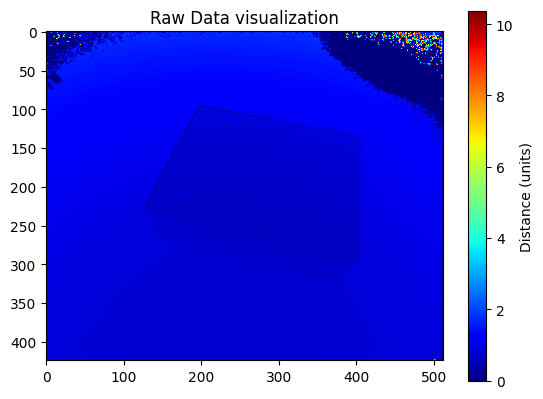

max shape


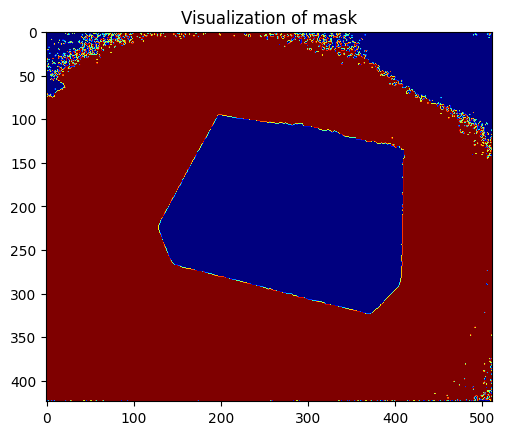

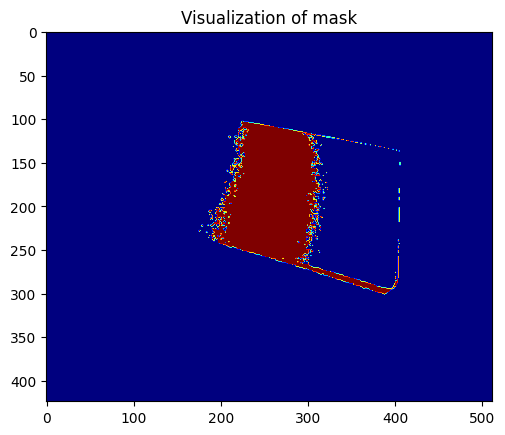

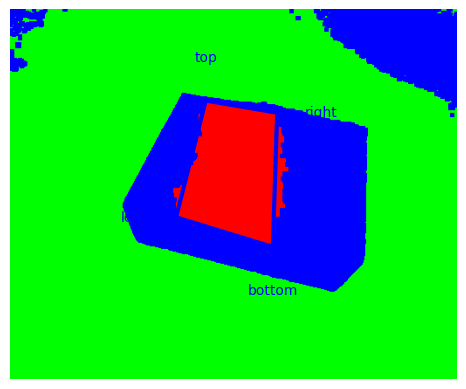

Distance between top and bottom (height) is: 0.77.
Length of the box is 161.01
Width of the box is 99.64
Time taken to run the code: 0.57 seconds.


In [176]:

example = '1'
data = loadData(example)

visualizeData(data)

A,D,PC = data['distances'+example], data['amplitudes'+example],data['cloud'+example]

#time calculation
start_time = time.time()

#get bottom plane
best_floor_plane, max_inliers = pre_find_floor_plane(PC, 0.04,100, 5,100)

#visualize mask here
mask = getMask(PC, max_inliers)
visualize_mask(mask)

#get top mask
largest_component, best_top_plane = pre_find_top_plane(PC, mask, 5,100 )
#get corners
corners = find_corners(largest_component)

end_time = time.time()
#print(corners)
#apply morphological
#structuring_element
#shape of the elem is rectangular (5,5)
struc_elem = np.ones((5, 5), np.uint8)
#kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
bool_closed = closing(mask, struc_elem)

box_visualization(bool_closed,largest_component,PC.shape,corners)

height = compute_height(best_floor_plane,best_top_plane)


print(f"Distance between top and bottom (height) is: {format(height, '.2f')}.")

length, width= calculate_dimensions(corners)

print('Length of the box is', format(length, '.2f'))
print('Width of the box is', format(width, '.2f'))

elapsed_time = end_time - start_time

print(f"Time taken to run the code: {format(elapsed_time, '.2f')} seconds.")

## Choosing three different value of M and calculating the time budget for all.

In [179]:
def run_example(example , M):
    #example = str(example)
    data = loadData(example)

    visualizeData(data)

    A,D,PC = data['distances'+example], data['amplitudes'+example],data['cloud'+example]

    #time calculation
    start_time = time.time()

    #get bottom plane
    best_floor_plane, max_inliers = pre_find_floor_plane(PC, 0.04,100, 5,M)

    #visualize mask here
    mask = getMask(PC, max_inliers)
    visualize_mask(mask)

    #get top mask
    largest_component, best_top_plane = pre_find_top_plane(PC, mask, 5,M )
    #get corners
    corners = find_corners(largest_component)

    end_time = time.time()
    #print(corners)
    #apply morphological
    #structuring_element
    #shape of the elem is rectangular (5,5)
    struc_elem = np.ones((5, 5), np.uint8)
    #kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    bool_closed = closing(mask, struc_elem)

    box_visualization(bool_closed,largest_component,PC.shape,corners)

    height = compute_height(best_floor_plane,best_top_plane)


    print(f"Distance between top and bottom (height) is: {format(height, '.2f')}.")

    length, width= calculate_dimensions(corners)

    print('Length of the box is', format(length, '.2f'))
    print('Width of the box is', format(width, '.2f'))

    elapsed_time = end_time - start_time

    print(f"Time taken to run the code: {format(elapsed_time, '.2f')} seconds.")

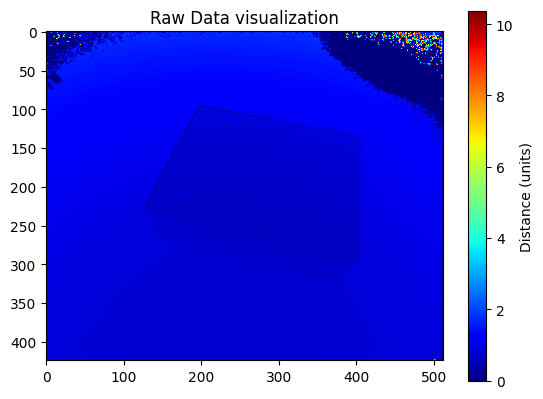

max shape


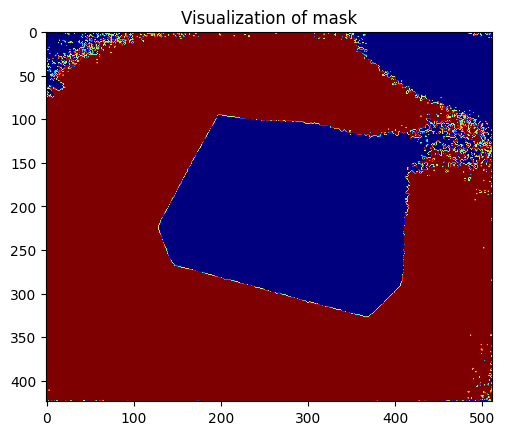

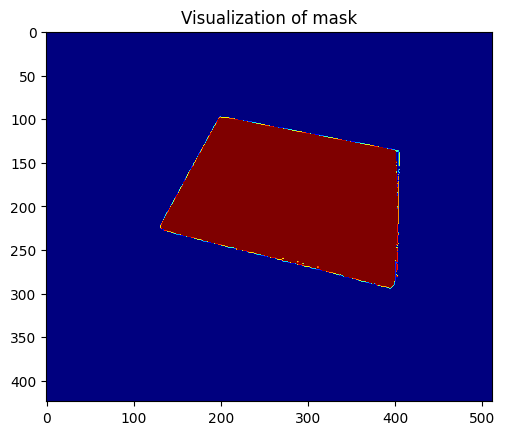

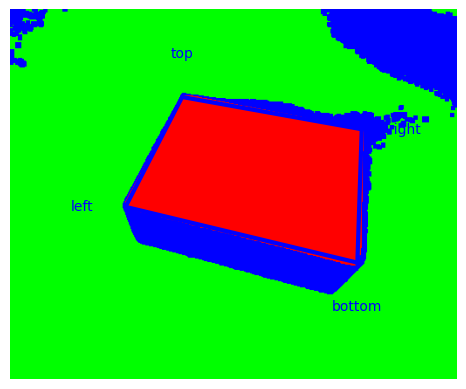

Distance between top and bottom (height) is: 0.81.
Length of the box is 261.18
Width of the box is 147.43
Time taken to run the code: 0.59 seconds.


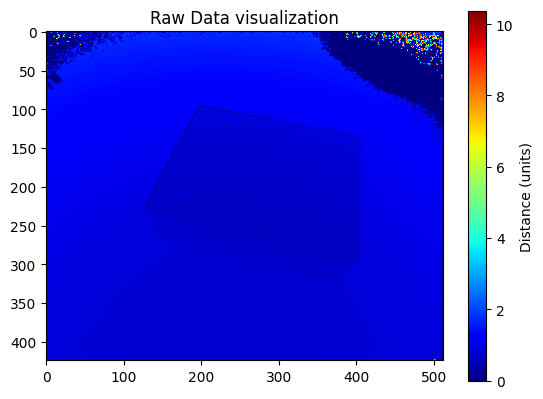

max shape


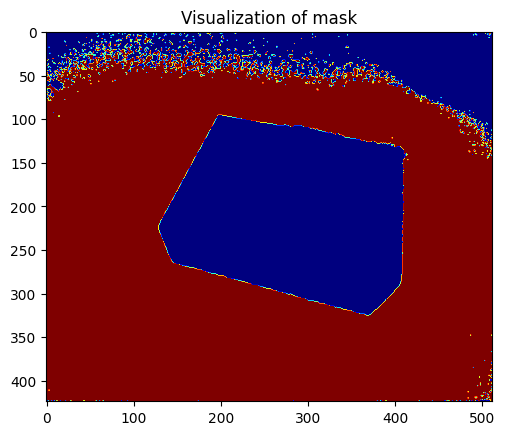

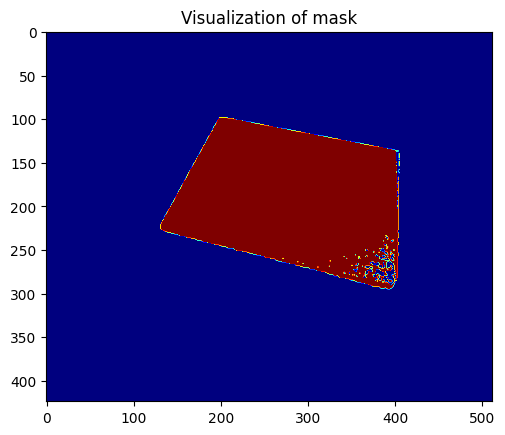

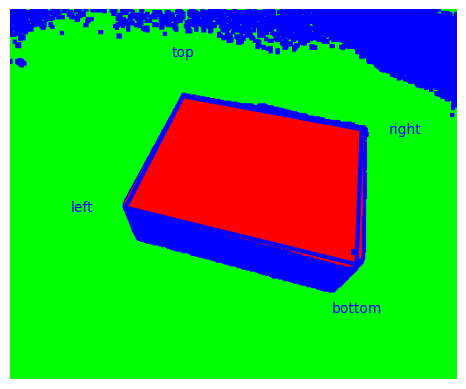

Distance between top and bottom (height) is: 0.70.
Length of the box is 261.03
Width of the box is 149.56
Time taken to run the code: 0.64 seconds.


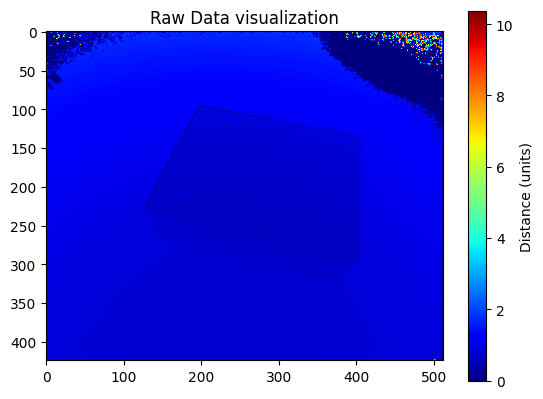

max shape


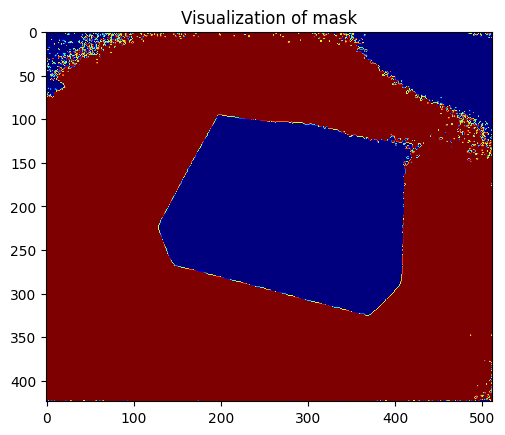

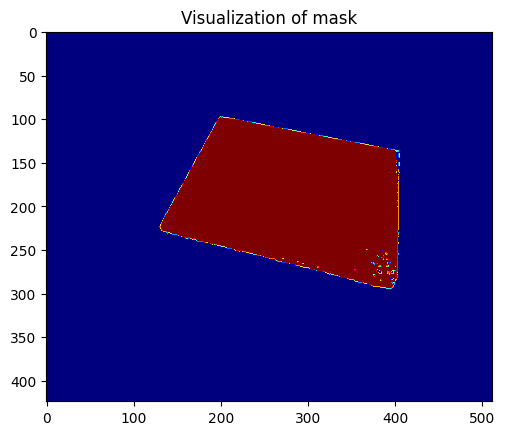

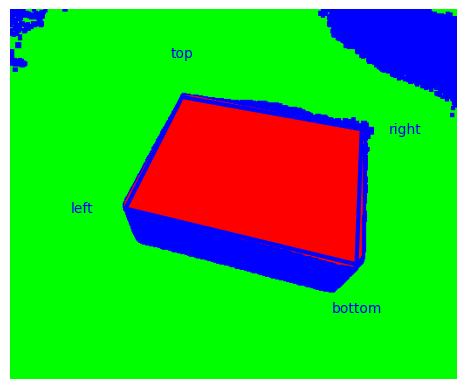

Distance between top and bottom (height) is: 0.70.
Length of the box is 261.26
Width of the box is 149.34
Time taken to run the code: 0.57 seconds.


In [180]:
M = [50, 100, 110] #number of hypothesis
example = '1'
for i in M:
    run_example(example , i)